In [1]:
!pip install dask_ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 11.0 MB/s eta 0:00:00


In [14]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
""" Use dask to explore the whole dataset"""
import dask.dataframe as dd 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dask_ml.preprocessing import Categorizer
from dask_ml.preprocessing import DummyEncoder
import dask.config
import lightgbm as lgb
import xgboost as xgb
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Jared's new data

In [29]:
train_new = dd.read_csv("drive/MyDrive/Raw/20230520-104214_train_official_fe.csv.gz")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/io/csv.py:543: UserWarning: Warning gzip compression does not support breaking apart files
Please ensure that each individual file can fit in memory and
use the keyword ``blocksize=None to remove this message``
Setting ``blocksize=None``
  warn(


In [30]:
train_new.columns

Index(['srch_id', 'site_id', 'visitor_location_country_id', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_location_score1', 'prop_location_score2',
       ...
       'srch_destination_id_srch_booking_window_max',
       'srch_destination_id_orig_destination_distance_mean',
       'srch_destination_id_orig_destination_distance_median',
       'srch_destination_id_orig_destination_distance_min',
       'srch_destination_id_orig_destination_distance_max', 'month',
       'day_of_week', 'GBM_target', 'avg_price_hotel', 'price_diff'],
      dtype='object', length=114)

In [33]:
cols_to_drop = ["GBM_target", "click_bool", "booking_bool", "random_bool", "position", "prop_review_score", "prop_location_score2", "orig_destination_distance"]

In [34]:
X = train_new.drop(cols_to_drop, axis=1).reset_index(drop=True).compute()
y = train_new["GBM_target"].values.compute()

In [35]:
from sklearn.model_selection import GroupShuffleSplit

# Split the data into train and test sets
idx_train, idx_test = next(GroupShuffleSplit(test_size=.40, n_splits=1, random_state = 7).split(X, groups=X['srch_id']))

X_train = X.iloc[idx_train]
X_test = X.iloc[idx_test]
y_train = y[idx_train]
y_test = y[idx_test]

In [36]:
train_data = lgb.Dataset(X_train, label=y_train, group=X_train.groupby('srch_id').size())
test_data = lgb.Dataset(X_test, label=y_test, group=X_test.groupby('srch_id').size())

In [37]:
# Set hyperparameters for LightGBM
params = {
    "objective": "lambdarank",
    "metric": "ndcg",
    "num_leaves": 30,
    "min_data_in_leaf":100,
    "learning_rate": 0.05,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": 0,
    "random_state": 42
}

In [38]:
lgb_model = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[train_data, test_data], verbose_eval=10, early_stopping_rounds=200)

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.859260 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[10]	training's ndcg@1: 0.507633	training's ndcg@2: 0.527361	training's ndcg@3: 0.548305	training's ndcg@4: 0.565695	training's ndcg@5: 0.580117	valid_1's ndcg@1: 0.487286	valid_1's ndcg@2: 0.506148	valid_1's ndcg@3: 0.526725	valid_1's ndcg@4: 0.544134	valid_1's ndcg@5: 0.558818
[20]	training's ndcg@1: 0.520138	training's ndcg@2: 0.539351	training's ndcg@3: 0.559697	training's ndcg@4: 0.577492	training's ndcg@5: 0.593277	valid_1's ndcg@1: 0.493073	valid_1's ndcg@2: 0.512863	valid_1's ndcg@3: 0.534298	valid_1's ndcg@4: 0.551787	valid_1's ndcg@5: 0.566226
[30]	training's ndcg@1: 0.52841	training's ndcg@2: 0.549035	training's ndcg@3: 0.570376	training's ndcg@4: 0.588698	training's ndcg@5: 0.60348	valid_1's ndcg@1: 0.496244	valid_1's ndcg@2: 0.516246	valid_1's ndcg@3

In [39]:
# Let's see top 25 features as identified by the lightgbm model.
print("Features importance...")
gain = lgb_model.feature_importance('gain')
feat_imp = pd.DataFrame({'feature':lgb_model.feature_name(), 
                         'split':lgb_model.feature_importance('split'), 
                         'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
print('Top 25 features:\n', feat_imp.head(25))

Features importance...
Top 25 features:
                                           feature  split      gain
9                                       price_usd    389  5.578071
105                                    price_diff    296  4.698994
32                          srch_id_price_usd_min    277  4.318679
30                         srch_id_price_usd_mean    230  3.511156
53               prop_id_prop_location_score2_max    188  3.171726
31                       srch_id_price_usd_median    227  2.934828
51            prop_id_prop_location_score2_median    203  2.818346
25               srch_id_prop_location_score2_max    158  2.693124
52               prop_id_prop_location_score2_min    189  2.605356
29          srch_id_prop_log_historical_price_max    154  2.354033
26         srch_id_prop_log_historical_price_mean    148  1.912236
50              prop_id_prop_location_score2_mean    138  1.877115
8                       prop_log_historical_price    156  1.832971
33                   

In [40]:
import joblib

In [41]:
joblib.dump(lgb_model, 'drive/MyDrive/Raw/trained_lightgbm_new.pkl')

['drive/MyDrive/Raw/trained_lightgbm_new.pkl']

### Previous Models

In [ ]:
test_1 = dd.read_csv("drive/MyDrive/Raw/test")

In [ ]:
train1 = dd.read_csv("drive/MyDrive/Raw/train1.csv")

In [ ]:
train1.shape[0].compute()

4958347

In [ ]:
all = train1.isna().sum().compute()

In [ ]:
all[all.values > 0]

prop_review_score                                       7364
prop_location_score2                                 1090348
orig_destination_distance                            1607782
srch_id_prop_location_score1_std                         136
srch_id_prop_log_historical_price_std                    393
srch_id_orig_destination_distance_mean               1607782
srch_id_orig_destination_distance_median             1607782
srch_id_orig_destination_distance_std                1607782
srch_id_orig_destination_distance_min                1607782
srch_id_orig_destination_distance_max                1607782
prop_id_prop_location_score1_std                     1237745
prop_id_prop_log_historical_price_std                  13280
prop_id_price_usd_std                                  12871
prop_id_srch_length_of_stay_std                        12868
prop_id_srch_booking_window_std                        12868
prop_id_orig_destination_distance_mean                 44886
prop_id_orig_destination

In [ ]:
train1[train1["srch_id_prop_log_historical_price_std"].isna()].head(10)["prop_log_historical_price"]

20097    6.21
20127    6.21
20609    6.21
21342    6.21
21606    6.21
21646    6.21
21693    6.21
21994    6.21
22011    6.21
22033    6.21
Name: prop_log_historical_price, dtype: float64

In [ ]:
test_1.head(2)

,Unnamed: 0,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,...,srch_destination_id_srch_booking_window_mean,srch_destination_id_srch_booking_window_median,srch_destination_id_srch_booking_window_std,srch_destination_id_srch_booking_window_min,srch_destination_id_srch_booking_window_max,srch_destination_id_orig_destination_distance_mean,srch_destination_id_orig_destination_distance_median,srch_destination_id_orig_destination_distance_std,srch_destination_id_orig_destination_distance_min,srch_destination_id_orig_destination_distance_max
0,0,1,2013-02-02 15:27:40,24,216,NaN,NaN,219,3180,3,...,21.522428,10.0,35.988685,0,229,710.258866,162.725,884.619076,0.75,2606.14
1,1,5883,2012-12-07 06:01:55,5,219,NaN,NaN,219,3180,3,...,21.522428,10.0,35.988685,0,229,710.258866,162.725,884.619076,0.75,2606.14


In [ ]:
test_1['prop_review_score'].head(2)

0    4.5
1    4.5
Name: prop_review_score, dtype: float64

In [ ]:
for col in ['prop_review_score', 'prop_location_score2', 'orig_destination_distance']:
    median_value = test_1[col].quantile(0.5).compute()
    print(median_value)
    test_1[col].fillna(median_value)

In [ ]:
all = test_1.isna().sum().compute()


In [ ]:
all

Unnamed: 0                                                   0
srch_id                                                      0
date_time                                                    0
site_id                                                      0
visitor_location_country_id                                  0
                                                         ...  
srch_destination_id_orig_destination_distance_mean      126870
srch_destination_id_orig_destination_distance_median    126870
srch_destination_id_orig_destination_distance_std       126870
srch_destination_id_orig_destination_distance_min       126870
srch_destination_id_orig_destination_distance_max       126870
Length: 145, dtype: int64

In [ ]:
type(all)

pandas.core.series.Series

In [ ]:
all.index[all.values > 0]

Index(['visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_review_score',
       'prop_location_score2', 'srch_query_affinity_score',
       'orig_destination_distance', 'comp1_rate', 'comp1_inv',
       'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv',
       'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv',
       'comp7_rate_percent_diff', 'comp8_rate', 'comp8_inv',
       'comp8_rate_percent_diff', 'srch_id_prop_location_score1_std',
       'srch_id_prop_log_historical_price_std',
       'srch_id_orig_destination_distance_mean',
       'srch_id_orig_destination_distance_median',
       'srch_id_orig_destination_distance_std',
       'srch_id_orig_destination_distance_min',
       'srch_id_orig_destination_distance_max',
       'p

In [ ]:
train = dd.read_csv("drive/MyDrive/Raw/training_set_VU_DM.csv")
test = dd.read_csv("drive/MyDrive/Raw/test_set_VU_DM.csv")

In [ ]:
test_1['date_time'] = dd.to_datetime(test_1['date_time'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
# Current price - average price per Property ID & Average price of a property
avg_price_hotel = test_1.groupby("prop_id")["price_usd"].mean().compute()
test_1 = test_1.merge(avg_price_hotel.rename("avg_price_hotel").reset_index(), on="prop_id")
test_1["price_diff"] = test_1["price_usd"] - test_1["avg_price_hotel"]

KeyError: ignored

In [ ]:
test_1["price_diff"] = test_1["price_usd"] - test_1["avg_price_hotel_y"]

In [ ]:
train1 = dd.read_csv("drive/MyDrive/Raw/train1.csv")

In [ ]:
test_1 = test_1.rename(columns={'avg_price_hotel_y': 'avg_price_hotel'})

In [ ]:
test_1.columns

Index(['Unnamed: 0', 'srch_id', 'date_time', 'site_id',
       'visitor_location_country_id', 'visitor_hist_starrating',
       'visitor_hist_adr_usd', 'prop_country_id', 'prop_id', 'prop_starrating',
       ...
       'srch_destination_id_srch_booking_window_median',
       'srch_destination_id_srch_booking_window_std',
       'srch_destination_id_srch_booking_window_min',
       'srch_destination_id_srch_booking_window_max',
       'srch_destination_id_orig_destination_distance_mean',
       'srch_destination_id_orig_destination_distance_median',
       'srch_destination_id_orig_destination_distance_std',
       'srch_destination_id_orig_destination_distance_min',
       'srch_destination_id_orig_destination_distance_max', 'avg_price_hotel'],
      dtype='object', length=146)

In [ ]:
missing_columns = [col for col in test_1.columns if col not in train1.columns]

In [ ]:
missing_columns2 = [col for col in train1.columns if col not in test_1.columns]

In [ ]:
print(missing_columns)

['srch_destination_id_price_usd_mean', 'srch_destination_id_price_usd_median', 'srch_destination_id_srch_length_of_stay_mean', 'srch_destination_id_srch_length_of_stay_median', 'srch_destination_id_srch_booking_window_mean', 'srch_destination_id_srch_booking_window_median', 'srch_destination_id_orig_destination_distance_mean', 'srch_destination_id_orig_destination_distance_median']


In [ ]:
test_1 = test_1.drop(columns=['visitor_hist_starrating', 'visitor_hist_adr_usd', 'srch_query_affinity_score', 'comp1_rate', 'comp1_inv', 'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv', 'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv', 'comp3_rate_percent_diff', 'comp4_rate','comp4_inv', 'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv', 'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv', 'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv', 'comp7_rate_percent_diff', 'comp8_rate', 'comp8_inv', 'comp8_rate_percent_diff', 'avg_price_hotel_x'])

In [ ]:
# Month and year
test_1["month"] = test_1["date_time"].dt.month
test_1["day_of_week"] = test_1["date_time"].dt.day_name()

In [ ]:
weekday = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}

# Use the map function to transform the weekday column
test_1["day_of_week"] = test_1["day_of_week"].map(weekday, meta=('day_of_week', 'int'))

In [ ]:
month_map = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

test_1['month'] = test_1['month'].map(month_map)

In [ ]:
import joblib

In [ ]:
model_trainned = joblib.load('drive/MyDrive/Raw/trained_model.pkl')


In [ ]:
predictions = model_trainned.predict(test_1)

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


In [ ]:
# Output the test data with rankings
test_data_ranked = test_1[['srch_id', 'prop_id']]
test_data_ranked['ranking'] = predictions
test_data_ranked = test_data_ranked.sort_values(['srch_id', 'ranking'], ascending=[True, False])
test_data_ranked = test_data_ranked[['srch_id', 'prop_id']]
test_data_ranked.to_csv('test_data_ranked.csv', index=False)

# Inspect Train Data

In [ ]:
train.columns

Index(['srch_id', 'date_time', 'site_id', 'visitor_location_country_id',
       'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'position', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score',
       'orig_destination_distance', 'random_bool', 'comp1_rate', 'comp1_inv',
       'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv',
       'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_rate'

In [ ]:
train.head(1)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0


In [ ]:
# Total Records:
len(train)

4958347

In [ ]:
# Total searches
len(train["srch_id"].unique())

199795

In [ ]:
# Total records clicked (%)
len(train[train["click_bool"]==1])/len(train)

0.04474858254172207

In [ ]:
# Total records booked (%)
len(train[train["booking_bool"]==1])/len(train)

0.027910511305481445

In [ ]:
# Searches with no clicks
df = train[["srch_id","click_bool"]].groupby('srch_id').max().compute()
len(df[df["click_bool"]==0])/len(df)

0.0

In [ ]:
# Searches with no bookings
df = train[["srch_id","booking_bool"]].groupby('srch_id').max().compute()
len(df[df["booking_bool"]==0])/len(df)

0.3073400235241122

In [ ]:
# Minimum properties displayed for each srch_id
train.groupby('srch_id').size().min().compute()

5

In [ ]:
# Maximum properties displayed for each srch_id
train.groupby('srch_id').size().max().compute()

38

In [ ]:
# Mean properties displayed for each srch_id
train.groupby('srch_id').size().mean().compute()

24.817172601916965

In [ ]:
# Mean number of clicks for each srch_id
df = train[["srch_id","click_bool"]].groupby('srch_id').sum().compute()
df["click_bool"].mean()

1.1105332966290449

In [ ]:
# Mean number of bookings for each srch_id
df = train[["srch_id","booking_bool"]].groupby('srch_id').sum().compute()
df["booking_bool"].mean()

0.6926599764758878

In [ ]:
# Maximum number of bookings per srch_id
df = train[["srch_id","booking_bool"]].groupby('srch_id').sum().compute()
df["booking_bool"].max()

1

#### Diagrams

In [ ]:
# Probability of clicking based on position (with all data)
df = train[["position","click_bool"]].groupby('position').sum().compute()
df1 = train[["position","click_bool"]].groupby('position').size().compute()

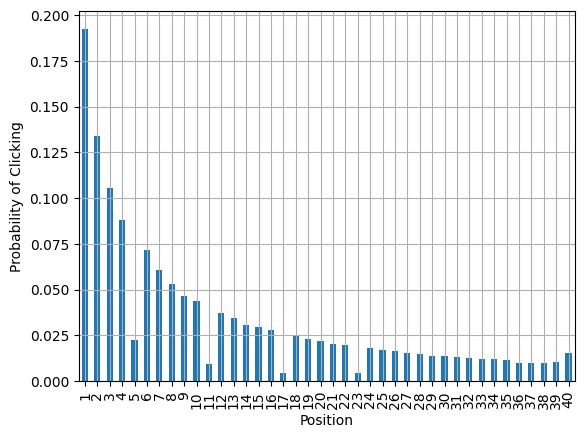

In [ ]:
data = df['click_bool']/df1
#plt.plot(data.index, data)
data.plot(kind='bar', legend=None)
plt.grid()
plt.xlabel("Position")
plt.ylabel("Probability of Clicking")
plt.show()


In [ ]:
# Probability of clicking based on position (just the randomized position data)
df = train[train["random_bool"] == 1][["position","click_bool"]].groupby('position').sum().compute()
df1 = train[train["random_bool"] == 1][["position","click_bool"]].groupby('position').size().compute()

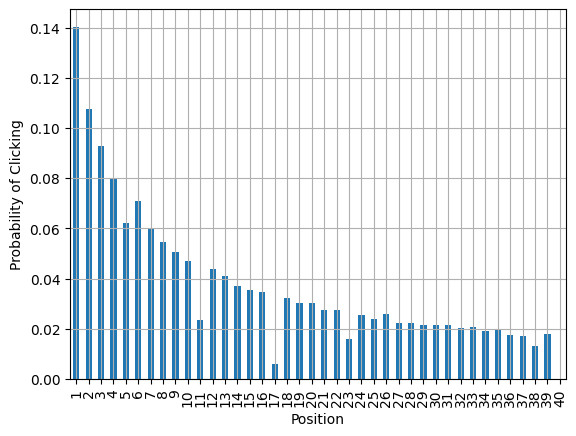

In [ ]:
data = df['click_bool']/df1
data.plot(kind='bar', legend=None)
plt.grid()
plt.xlabel("Position")
plt.ylabel("Probability of Clicking")
plt.show()

In [ ]:
# Probability of clicking based on position (with all data)
df = train[["position","booking_bool"]].groupby('position').sum().compute()
df1 = train[["position","booking_bool"]].groupby('position').size().compute()

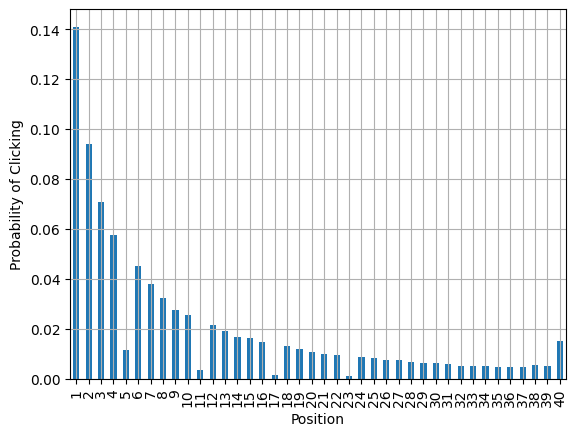

In [ ]:
data = df['booking_bool']/df1
#plt.plot(data.index, data)
data.plot(kind='bar', legend=None)
plt.grid()
plt.xlabel("Position")
plt.ylabel("Probability of Clicking")
plt.show()

In [ ]:
# Probability of clicking based on position (just the randomized position data)
df = train[train["random_bool"] == 1][["position","booking_bool"]].groupby('position').sum().compute()
df1 = train[train["random_bool"] == 1][["position","booking_bool"]].groupby('position').size().compute()

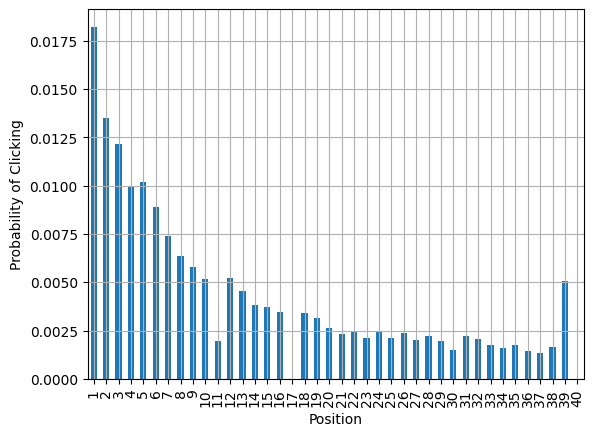

In [ ]:
data = df['booking_bool']/df1
#plt.plot(data.index, data)
data.plot(kind='bar', legend=None)
plt.grid()
plt.xlabel("Position")
plt.ylabel("Probability of Clicking")
plt.show()

In [ ]:
# TODO: FOR BOOKING + REPORT THAT PRICES ARE BOOKED LESS WHEN THEY ARE MORE EXPENSIVE


### Data Cleaning

#### 1. Merge competitors availability values
We tried merging the competitors data, but more than 50% of it has all nan values.

In [ ]:
comp_cols = [col for col in train.columns if "comp" in col]
df = train[comp_cols]
df_dropped = df.dropna(how="all").compute()

In [ ]:
len(df_dropped) / len(df)

0.6761071784608863

#### 2. Dropping: NaN threshold

In [ ]:
# Get distributions of nans
isnans = train.isna().sum().compute()

In [ ]:
isnans

srch_id                              0
date_time                            0
site_id                              0
visitor_location_country_id          0
visitor_hist_starrating        4706481
visitor_hist_adr_usd           4705359
prop_country_id                      0
prop_id                              0
prop_starrating                      0
prop_review_score                 7364
prop_brand_bool                      0
prop_location_score1                 0
prop_location_score2           1090348
prop_log_historical_price            0
position                             0
price_usd                            0
promotion_flag                       0
srch_destination_id                  0
srch_length_of_stay                  0
srch_booking_window                  0
srch_adults_count                    0
srch_children_count                  0
srch_room_count                      0
srch_saturday_night_bool             0
srch_query_affinity_score      4640941
orig_destination_distance

In [ ]:
# Drop columns with more than 50% nan
nan_percentage = train.isna().sum().compute() / len(train)
columns_to_drop = nan_percentage[nan_percentage > 0.5].index.tolist()
train = train.drop(columns_to_drop, axis=1)

#### 3. Data Imputation on the new train_fe dataset

In [ ]:
train1 = train.copy()

In [ ]:
with_nan = train.columns[train.isnull().any()].tolist()

In [ ]:
with_nan

['prop_review_score', 'prop_location_score2', 'orig_destination_distance']

In [ ]:
train1.groupby("prop_country_id")["prop_review_score"].head(10)

In [ ]:
# TODO : FIX THIS PART
# Compute first quartile by prop_country_id
for col in ['prop_review_score', 'prop_location_score2', 'orig_destination_distance']:
  first_quartile_by_prop_country_and_col = train1.groupby("prop_country_id")[col].apply(lambda x: x.quantile(0.25))
  
  for country, first_quartile in first_quartile_by_prop_country_and_col.iteritems():
    train1[train1["prop_country_id"] == country][col] = train1[train1["prop_country_id"] == country][col].fillna(first_quartile)

<ipython-input-162-7602e94087a4>:3: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  first_quartile_by_prop_country_and_col = train1.groupby("prop_country_id")[col].apply(lambda x: x.quantile(0.25))
/usr/local/lib/python3.10/dist-packages/dask/dataframe/core.py:3766: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  warnings.warn(


In [ ]:
train1.isna().sum().compute()

srch_id                              0
date_time                            0
site_id                              0
visitor_location_country_id          0
prop_country_id                      0
prop_id                              0
prop_starrating                      0
prop_review_score                 7364
prop_brand_bool                      0
prop_location_score1                 0
prop_location_score2           1090348
prop_log_historical_price            0
position                             0
price_usd                            0
promotion_flag                       0
srch_destination_id                  0
srch_length_of_stay                  0
srch_booking_window                  0
srch_adults_count                    0
srch_children_count                  0
srch_room_count                      0
srch_saturday_night_bool             0
orig_destination_distance      1607782
random_bool                          0
click_bool                           0
booking_bool             

In [ ]:
train1.head()

,srch_id,date_time,site_id,visitor_location_country_id,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,...,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,orig_destination_distance,random_bool,click_bool,booking_bool
0,1,2013-04-04 08:32:15,12,187,219,893,3,3.5,1,2.83,...,1,0,4,0,1,1,338.9175,1,0,0
1,1,2013-04-04 08:32:15,12,187,219,10404,4,4.0,1,2.20,...,1,0,4,0,1,1,338.9175,1,0,0
2,1,2013-04-04 08:32:15,12,187,219,21315,3,4.0,1,2.20,...,1,0,4,0,1,1,338.9175,1,0,0
3,1,2013-04-04 08:32:15,12,187,219,27348,2,3.5,1,2.83,...,1,0,4,0,1,1,338.9175,1,0,0
4,1,2013-04-04 08:32:15,12,187,219,29604,4,4.0,1,2.64,...,1,0,4,0,1,1,338.9175,1,0,0


#### 4. Create new features

In [ ]:
from tqdm import tqdm

In [ ]:
# TODO: prop_location_score2 as it still had missing values
# Categorical features
features = ['prop_location_score1', 'prop_log_historical_price','price_usd', 'srch_length_of_stay', 'srch_booking_window', 'orig_destination_distance']

# Aggregation functions
agg_functions = ['mean', 'median', 'std', 'min', 'max']

for x in tqdm(['srch_id', 'prop_id', 'srch_destination_id']): 
  for y in tqdm(features): 
    for z in agg_functions: 
      grouped_test = test.groupby(x)[[y]].agg(z, shuffle='tasks').compute()
      grouped_test.rename(columns={y: '{}_{}_{}'.format(x, y, z)}, inplace=True)
      test = test.merge(grouped_test, on=x)

100%|██████████| 3/3 [4:38:30<00:00, 5570.05s/it]


In [ ]:
test.to_csv("drive/MyDrive/Raw/test.csv", single_file=True) 

NameError: ignored

In [ ]:
test.head(5)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,srch_destination_id_srch_booking_window_mean,srch_destination_id_srch_booking_window_median,srch_destination_id_srch_booking_window_std,srch_destination_id_srch_booking_window_min,srch_destination_id_srch_booking_window_max,srch_destination_id_orig_destination_distance_mean,srch_destination_id_orig_destination_distance_median,srch_destination_id_orig_destination_distance_std,srch_destination_id_orig_destination_distance_min,srch_destination_id_orig_destination_distance_max
0,1,2013-02-02 15:27:40,24,216,NaN,NaN,219,3180,3,4.5,...,21.522428,10.0,35.988685,0,229,710.258866,162.725,884.619076,0.75,2606.14
1,5883,2012-12-07 06:01:55,5,219,NaN,NaN,219,3180,3,4.5,...,21.522428,10.0,35.988685,0,229,710.258866,162.725,884.619076,0.75,2606.14
2,9502,2013-02-19 13:41:39,5,219,NaN,NaN,219,3180,3,4.5,...,21.522428,10.0,35.988685,0,229,710.258866,162.725,884.619076,0.75,2606.14
3,12537,2012-12-06 11:44:41,5,219,NaN,NaN,219,3180,3,4.5,...,21.522428,10.0,35.988685,0,229,710.258866,162.725,884.619076,0.75,2606.14
4,14954,2013-03-09 10:47:29,5,219,NaN,NaN,219,3180,3,4.5,...,21.522428,10.0,35.988685,0,229,710.258866,162.725,884.619076,0.75,2606.14


In [ ]:
#train1.to_csv("drive/MyDrive/Raw/train1.csv", single_file=True)

['/content/drive/MyDrive/Raw/train1.csv']

In [ ]:
#train1.columns

Index(['srch_id', 'date_time', 'site_id', 'visitor_location_country_id',
       'prop_country_id', 'prop_id', 'prop_starrating', 'prop_review_score',
       'prop_brand_bool', 'prop_location_score1',
       ...
       'srch_destination_id_price_usd_max',
       'srch_destination_id_srch_length_of_stay_std',
       'srch_destination_id_srch_length_of_stay_min',
       'srch_destination_id_srch_length_of_stay_max',
       'srch_destination_id_srch_booking_window_std',
       'srch_destination_id_srch_booking_window_min',
       'srch_destination_id_srch_booking_window_max',
       'srch_destination_id_orig_destination_distance_std',
       'srch_destination_id_orig_destination_distance_min',
       'srch_destination_id_orig_destination_distance_max'],
      dtype='object', length=112)

#### 5. Load the data after initial feature engineering

In [ ]:
# TODO: Estimated positioning

# TODO: The average price of hotels in the same region as the property being considered (during the same dates?)
# The standard deviation of hotel prices in the same region as the property being considered
# The difference between the price of the property being considered and the average price of hotels in the same region for the same dates

# TODO: Mean, median, std, min, max - for data imputation variables
# 0,1,2 - GBM_target (gradient boosted machine)
  # Group numerical by search_id, prop-id, destination id

In [ ]:
# TODO: VERIFY IF THESE WILL BE NEEDED: srch_adults_count, srch_children_count, srch_room_count    

In [ ]:
train_fe = dd.read_csv("drive/MyDrive/Raw/train1.csv")

In [ ]:
# Month and year
train_fe["month"] = train_fe["date_time"].dt.month
train_fe["day_of_week"] = train_fe["date_time"].dt.day_name()

weekday = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}

# Use the map function to transform the weekday column
train_fe["day_of_week"] = train_fe["day_of_week"].map(weekday, meta=('day_of_week', 'int'))


month_map = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

train_fe['month'] = train_fe['month'].map(month_map)

AttributeError: ignored

In [ ]:
train_fe.head(5)

,Unnamed: 0,srch_id,date_time,site_id,visitor_location_country_id,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,...,srch_destination_id_price_usd_max,srch_destination_id_srch_length_of_stay_std,srch_destination_id_srch_length_of_stay_min,srch_destination_id_srch_length_of_stay_max,srch_destination_id_srch_booking_window_std,srch_destination_id_srch_booking_window_min,srch_destination_id_srch_booking_window_max,srch_destination_id_orig_destination_distance_std,srch_destination_id_orig_destination_distance_min,srch_destination_id_orig_destination_distance_max
0,0,1,2013-04-04 08:32:15,12,187,219,893,3,3.5,1,...,2094.59,1.205435,1,16,41.431273,0,276,2152.666612,0.01,9359.52
1,1,896,2013-05-09 22:14:57,5,2,219,893,3,3.5,1,...,2094.59,1.205435,1,16,41.431273,0,276,2152.666612,0.01,9359.52
2,2,1495,2013-04-24 02:24:02,5,219,219,893,3,3.5,1,...,2094.59,1.205435,1,16,41.431273,0,276,2152.666612,0.01,9359.52
3,3,2052,2013-01-11 08:10:27,5,219,219,893,3,3.5,1,...,2094.59,1.205435,1,16,41.431273,0,276,2152.666612,0.01,9359.52
4,4,2056,2013-03-07 23:19:22,5,219,219,893,3,3.5,1,...,2094.59,1.205435,1,16,41.431273,0,276,2152.666612,0.01,9359.52


In [ ]:
train_fe = train_fe.assign(GBM_target=(train_fe['booking_bool']*5 + ((1-train_fe['booking_bool'])*train_fe['click_bool'])))

In [ ]:
# Take 10% of the training data
data_lightgbm = train_fe.sample(frac=0.1, random_state=42)

In [ ]:
# Assign the target variable
cols_to_drop = ["Unnamed: 0", "GBM_target","date_time", "click_bool", "booking_bool", "random_bool", "position", "prop_review_score", "prop_location_score2", "orig_destination_distance"]
X = data_lightgbm.drop(cols_to_drop, axis=1).reset_index(drop=True).compute()
y = data_lightgbm["GBM_target"].values.compute()

In [ ]:
print(X.columns)

Index(['srch_id', 'site_id', 'visitor_location_country_id', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_brand_bool', 'prop_location_score1',
       'prop_log_historical_price', 'price_usd',
       ...
       'srch_destination_id_price_usd_max',
       'srch_destination_id_srch_length_of_stay_std',
       'srch_destination_id_srch_length_of_stay_min',
       'srch_destination_id_srch_length_of_stay_max',
       'srch_destination_id_srch_booking_window_std',
       'srch_destination_id_srch_booking_window_min',
       'srch_destination_id_srch_booking_window_max',
       'srch_destination_id_orig_destination_distance_std',
       'srch_destination_id_orig_destination_distance_min',
       'srch_destination_id_orig_destination_distance_max'],
      dtype='object', length=104)


#### 5. Data Normalisation

In [ ]:
# Z scores. standdard scaler from skilearn

In [ ]:
# Transform day_week and month into numbers

### Data Modelling

In [ ]:
from sklearn.model_selection import GroupShuffleSplit

# Split the data into train and test sets
idx_train, idx_test = next(GroupShuffleSplit(test_size=.40, n_splits=1, random_state = 7).split(X, groups=X['srch_id']))

X_train = X.iloc[idx_train]
X_test = X.iloc[idx_test]
y_train = y[idx_train]
y_test = y[idx_test]

### CatBoost

In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 11.6 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRanker
from sklearn.model_selection import GridSearchCV

In [ ]:
# Define the CatBoost ranking model
model_cat = CatBoostRanker(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=3,
    loss_function='YetiRank',
    random_seed=42,
    custom_metric=['NDCG']
)

In [ ]:
model_cat.fit(
    X_train,
    y_train,
    group_id=np.array(X_train.groupby("srch_id").size()),
    eval_set=(X_test, y_test),
    use_best_model=True,
    verbose=10
)

CatBoostError: ignored

In [ ]:
y_pred = best_model.predict(X_test)

In [ ]:
joblib.dump(model_cat, 'drive/MyDrive/Raw/model_cat.pkl')

### XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [4, 6, 8],
    'n_estimators': [100, 200, 300],
    'subsample': [0.5, 0.75, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

In [ ]:
xgb_model = xgb.XGBRanker(
    tree_method='gpu_hist',
    booster='gbtree',
    objective='rank:ndcg',
    random_state=42,
    learning_rate=0.1,
    colsample_bytree=0.9, 
    eta=0.05, 
    max_depth=6, 
    n_estimators=110, 
    subsample=0.75 
)

In [ ]:
xgb_model.fit(X_train, y_train, group=X_train.groupby("srch_id").size(), verbose=True, eval_metric = "ndcg")

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=0.9,
          early_stopping_rounds=None, enable_categorical=False, eta=0.05,
          eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
          grow_policy=None, importance_type=None, interaction_constraints=None,
          learning_rate=0.1, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, n_estimators=110, n_jobs=None,
          num_parallel_tree=None, objective='rank:ndcg', ...)

In [ ]:
y_pred = xgb_model.predict(X_test)

In [ ]:
print(y_pred)

[-0.09010413 -0.14075942  0.16477078 ... -0.29232398 -0.17247637
 -0.74291533]


In [ ]:
test_data_ranked = X_test[['srch_id', 'prop_id']]
test_data_ranked['ranking'] = y_pred
test_data_ranked = test_data_ranked.sort_values(['srch_id', 'ranking'], ascending=[True, False])
test_data_ranked = test_data_ranked[['srch_id', 'prop_id']]
#test_data_ranked.to_csv('test_data_ranked.csv', index=False)

<ipython-input-42-92b1db14384a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_ranked['ranking'] = y_pred


In [ ]:
print(test_data_ranked)

      srch_id  prop_id
1999       11   122888
5843       11    28364
2104       17    28503
2119       17    87596
1359       17    17795
...       ...      ...
4395   332761   101767
3394   332761    14750
84     332774   126441
2501   332777    85514
5061   332777     2501

[198329 rows x 2 columns]


In [ ]:
import joblib

In [ ]:
joblib.dump(xgb_model, 'drive/MyDrive/Raw/xgb_model.pkl')

['drive/MyDrive/Raw/xgb_model.pkl']

### LightGBM

In [ ]:
# Define the LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train, group=X_train.groupby('srch_id').size())
test_data = lgb.Dataset(X_test, label=y_test, group=X_test.groupby('srch_id').size())

In [ ]:
# Set hyperparameters for LightGBM
params = {
    "objective": "lambdarank",
    "metric": "ndcg",
    "num_leaves": 30,
    "min_data_in_leaf":100,
    "learning_rate": 0.05,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": 0,
    "random_state": 42
}

In [ ]:
# Train the LightGBM model
lgb_model = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[train_data, test_data], verbose_eval=10, early_stopping_rounds=200)

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.410096 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[10]	training's ndcg@1: 0.960411	training's ndcg@2: 0.974503	training's ndcg@3: 0.979898	training's ndcg@4: 0.981803	training's ndcg@5: 0.982388	valid_1's ndcg@1: 0.990664	valid_1's ndcg@2: 0.99561	valid_1's ndcg@3: 0.996255	valid_1's ndcg@4: 0.996354	valid_1's ndcg@5: 0.996354
[20]	training's ndcg@1: 0.963124	training's ndcg@2: 0.976507	training's ndcg@3: 0.981543	training's ndcg@4: 0.983231	training's ndcg@5: 0.983707	valid_1's ndcg@1: 0.991043	valid_1's ndcg@2: 0.99585	valid_1's ndcg@3: 0.996432	valid_1's ndcg@4: 0.996513	valid_1's ndcg@5: 0.996518
[30]	training's ndcg@1: 0.965509	training's ndcg@2: 0.978006	training's ndcg@3: 0.982785	training's ndcg@4: 0.984267	training's ndcg@5: 0.98473	valid_1's ndcg@1: 0.991199	valid_1's ndcg@2: 0.995868	valid_1's ndcg@3:

In [ ]:
# Let's see top 25 features as identified by the lightgbm model.
print("Features importance...")
gain = lgb_model.feature_importance('gain')
feat_imp = pd.DataFrame({'feature':lgb_model.feature_name(), 
                         'split':lgb_model.feature_importance('split'), 
                         'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
print('Top 25 features:\n', feat_imp.head(25))

Features importance...
Top 25 features:
                                      feature  split      gain
9                                  price_usd    343  4.344056
35                     srch_id_price_usd_min    297  4.049846
21                                price_diff    220  2.925430
33                  srch_id_price_usd_median    211  2.339575
26          srch_id_prop_location_score1_max    142  2.094811
32                    srch_id_price_usd_mean    184  2.011114
36                     srch_id_price_usd_max    199  1.813429
24          srch_id_prop_location_score1_std    192  1.791777
5                            prop_starrating     99  1.772103
0                                    srch_id    239  1.766968
34                     srch_id_price_usd_std    209  1.760575
29     srch_id_prop_log_historical_price_std    198  1.716680
49     srch_id_orig_destination_distance_std    212  1.705721
7                       prop_location_score1    179  1.697674
61     prop_id_prop_log_histo

In [ ]:
# Make predictions on the test set
y_pred = lgb_model.predict(X_test)

In [ ]:
display(y_pred)

array([-0.20414279,  0.01228565, -0.22171491, ..., -0.13627187,
        0.00959431, -0.5154075 ])

In [ ]:
# Output the test data with rankings
test_data_ranked = X_test[['srch_id', 'prop_id']]
test_data_ranked['ranking'] = y_pred
test_data_ranked = test_data_ranked.sort_values(['srch_id', 'ranking'], ascending=[True, False])
test_data_ranked = test_data_ranked[['srch_id', 'prop_id']]
test_data_ranked.to_csv('test_data_ranked.csv', index=False)

<ipython-input-96-02751a41f81f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_ranked['ranking'] = y_pred


In [ ]:
joblib.dump(lgb_model, 'drive/MyDrive/Raw/trained_model1.pkl')